## 초기 EDA

### 신고/차단 관련 데이터 명세

In [1]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import koreanize_matplotlib
from google.cloud import storage
import gcsfs

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_timelinereport.parquet"
accounts_timelinereport = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

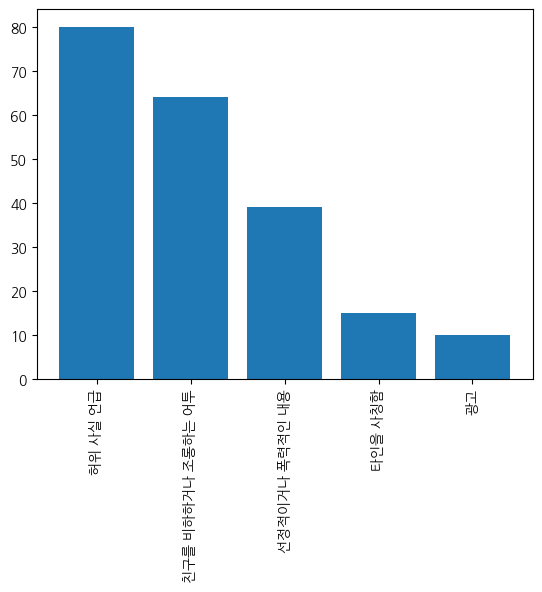

In [32]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.bar(accounts_timelinereport['reason'].value_counts().reset_index()['reason'], height=accounts_timelinereport['reason'].value_counts().reset_index()['count'])
plt.xticks(rotation=90)
plt.show()

In [3]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_blockrecord.parquet"
accounts_blockrecord = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [33]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user.parquet"
accounts_user = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [106]:
# 신고내역과 차단내역(accounts_blockrecord) 간의 관계 조사
df_merge_block = accounts_timelinereport.merge(accounts_blockrecord, left_on=['user_id','reported_user_id'], right_on=['user_id','block_user_id'],suffixes=('_report', '_block'))
df_merge_block

,reason_report,created_at_report,reported_user_id,user_id,user_question_record_id,reason_block,created_at_block,block_user_id
0,허위 사실 언급,2023-05-12 02:48:56,1150928,1137878,26226336,모르는 사람임,2023-05-14 02:55:26,1150928


In [ ]:
# block_user_id_list 여러 행으로 explode
accounts_user_nan = accounts_user.replace('[]', np.nan)
accounts_user_dropna = accounts_user_nan.dropna()
accounts_user_dropna['block_user_id_list'] = accounts_user_dropna['block_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_explode = accounts_user_dropna[['id','block_user_id_list']].explode('block_user_id_list')
accounts_user_explode

/tmp/ipykernel_226/177197795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_user_dropna['block_user_id_list'] = accounts_user_dropna['block_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


,id,block_user_id_list
162,837615,839155
208,837689,834325
285,837784,834325
287,837786,1158705
287,837786,1108926
...,...,...
668524,1574460,1576077
668524,1574460,1576581
668575,1574512,1005876
670207,1576284,1349412


In [125]:
# 신고내역과 차단내역(block_user_id_list) 간의 관계 조사
df_merge_ban = accounts_timelinereport.merge(accounts_user_explode, left_on=['user_id','reported_user_id'], right_on=['id','block_user_id_list'],suffixes=('_report', '_ban'))
df_merge_ban

,reason,created_at,reported_user_id,user_id,user_question_record_id,id,block_user_id_list


In [ ]:
# hide_user_id_list 여러 행으로 explode
accounts_user_dropna['hide_user_id_list'] = accounts_user_dropna['hide_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_explode = accounts_user_dropna[['id','hide_user_id_list']].explode('hide_user_id_list')
accounts_user_explode

/tmp/ipykernel_226/1497952159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_user_dropna['hide_user_id_list'] = accounts_user_dropna['hide_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


,id,hide_user_id_list
162,837615,837661
208,837689,838168
208,837689,837745
285,837784,837684
285,837784,839155
...,...,...
668575,1574512,1129856
670207,1576284,1349412
672023,1578333,1578352
672023,1578333,1578399


In [127]:
# 신고내역과 숨김내역(hide_user_id_list) 간의 관계 조사
df_merge_hide = accounts_timelinereport.merge(accounts_user_explode, left_on=['user_id','reported_user_id'], right_on=['id','hide_user_id_list'],suffixes=('_report', '_hide'))
df_merge_hide

,reason,created_at,reported_user_id,user_id,user_question_record_id,id,hide_user_id_list


In [161]:
ban_status_total = accounts_user['ban_status'].value_counts().reset_index()
ban_status_total

,ban_status,count
0,N,668432
1,W,7855
2,NB,608
3,RB,190


In [155]:
import matplotlib.pyplot as plt

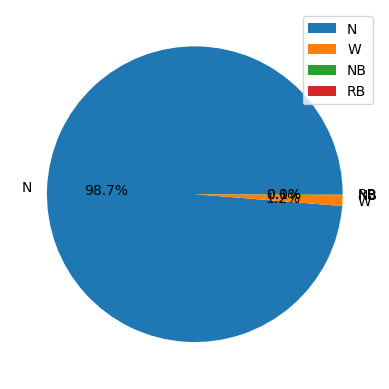

In [172]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(ban_status_total['count'], labels=ban_status_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [173]:
# 총 신고 횟수와 ban_status 간의 관계

report_cnt = accounts_timelinereport['reported_user_id'].value_counts().reset_index()
ban_status = accounts_user[['id','ban_status']]
merge_report_ban = pd.merge(report_cnt, ban_status, left_on='reported_user_id', right_on='id')
report_ban_total = merge_report_ban['ban_status'].value_counts().reset_index()

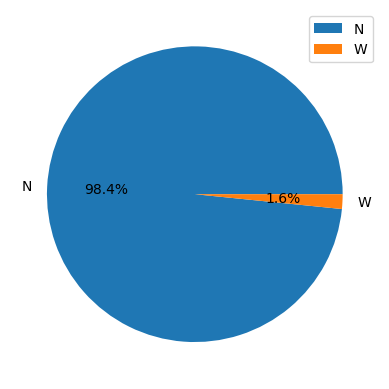

In [174]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(report_ban_total['count'], labels=report_ban_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [175]:
# 총 차단 횟수와 ban_status 간의 관계

block_cnt = accounts_blockrecord['block_user_id'].value_counts().reset_index()
ban_status = accounts_user[['id','ban_status']]
merge_block_ban = pd.merge(block_cnt, ban_status, left_on='block_user_id', right_on='id')
block_ban_total = merge_block_ban['ban_status'].value_counts().reset_index()

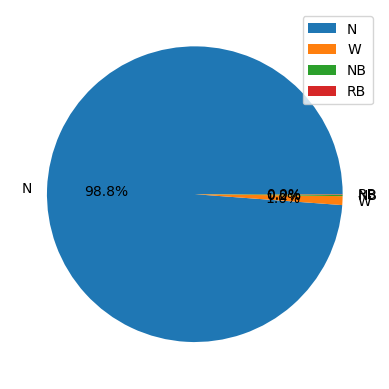

In [ ]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')
ax.pie(block_ban_total['count'], labels=block_ban_total['ban_status'], autopct='%1.1f%%',)
ax.legend()
plt.show()

In [150]:
merge_block_ban[merge_block_ban['ban_status']=='NB']['count'].value_counts()

count
1    23
4     1
3     1
2     1
Name: count, dtype: int64

In [151]:
merge_block_ban[merge_block_ban['ban_status']=='RB']['count'].value_counts()

count
1     5
2     2
11    1
Name: count, dtype: int64

### 친구는 쌍방일까?

In [6]:
accounts_user_frnd = accounts_user.copy()
accounts_user_frnd['friend_id_list'] = accounts_user_frnd['friend_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_frnd_explode = accounts_user_frnd[['id','friend_id_list']].explode('friend_id_list')
accounts_user_frnd_explode

,id,friend_id_list
0,831956,1292473
0,831956,913158
0,831956,1488461
0,831956,1064695
0,831956,1043565
...,...,...
677082,1583731,1583673
677083,1583732,1583673
677083,1583732,1583730
677083,1583732,1583731


In [7]:
accounts_user_frnd_explode = accounts_user_frnd_explode.dropna()
accounts_user_frnd_explode.shape

(36107386, 2)

In [8]:
accounts_user_frnd_explode = accounts_user_frnd_explode.reset_index(drop=True)

In [ ]:
pairs = set(zip(accounts_user_frnd_explode['id'], accounts_user_frnd_explode['friend_id_list']))

# 쌍방이어야 하는 반대 방향 쌍 생성
reverse_pairs = set((b, a) for (a, b) in pairs)

# 쌍방 아닌 것만 추출
non_mutual = pairs - reverse_pairs

In [12]:
print("쌍방 아닌 관계의 개수:")
print(len(non_mutual))

쌍방 아닌 관계의 개수:
183902


### 데이터 품질 검사

In [ ]:
# GCS 파일 시스템 객체 생성
fs = gcsfs.GCSFileSystem()

# GCS 버킷 내 모든 parquet 파일 경로 가져오기
parquet_paths = fs.glob("sprintda05_final_project/**/*.parquet")

# 파일명 기반으로 DataFrame 딕셔너리 만들기
dataframes = {}

for path in parquet_paths:
    df = pd.read_parquet(f"gs://{path}", engine="pyarrow")
    if 'id' in df.columns:
        df = df.drop(columns='id')
    
    # 파일명(확장자 포함)을 key로 사용
    filename = path.split("/")[-1]
    dataframes[filename] = df

In [8]:
# enumerate로 사용하기
for idx, (filename, df) in enumerate(dataframes.items()):
    print(f"[{idx}] {filename}: {df.shape}")
    # 원하는 작업 수행
    # print(df.replace('[]', np.nan).isna().sum())
    for col in df.columns:
        count = (df[col] == '[]').sum()
        print(f"{col}\t{count}")
    print()

[0] device_properties.parquet: (252380, 3)
device_id	0
device_model	0
device_vendor	0

[1] hackle_events.parquet: (11441319, 10)
event_id	0
event_datetime	0
event_key	0
session_id	0
item_name	0
page_name	0
friend_count	0
votes_count	0
heart_balance	0
question_id	0

[2] hackle_properties.parquet: (525350, 7)
session_id	0
user_id	0
language	0
osname	0
osversion	0
versionname	0
device_id	0

[3] user_properties.parquet: (230819, 5)
user_id	0
class	0
gender	0
grade	0
school_id	0

[4] accounts_attendance.parquet: (349637, 2)
attendance_date_list	20945
user_id	0

[5] accounts_blockrecord.parquet: (19482, 4)
reason	0
created_at	0
block_user_id	0
user_id	0

[6] accounts_failpaymenthistory.parquet: (163, 4)
productId	0
phone_type	0
created_at	0
user_id	0

[7] accounts_friendrequest.parquet: (17147175, 5)
status	0
created_at	0
updated_at	0
receive_user_id	0
send_user_id	0

[8] accounts_group.parquet: (84515, 3)
grade	0
class_num	0
school_id	0

[9] accounts_nearbyschool.parquet: (59500, 3)
distanc

## 전처리

### accounts_user

In [15]:
import pandas as pd
import ast
from google.cloud import storage

In [10]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user.parquet"
df = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [11]:
df.shape

(677085, 16)

In [ ]:
# accounts_user['point'] IQR*3 이상치 처리
point_iqr = df['point'].quantile(.75) - df['point'].quantile(.25)
point_upper_bound = df['point'].quantile(.75) + 3 * point_iqr
df = df[df['point']<=point_upper_bound]

In [13]:
df.shape

(663207, 16)

In [17]:
# len(accounts_user['friend_id_list']) 상위 1% 이상치 처리
df['friend_cnt'] = len(df['friend_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x))
friend_upper_bound = df['friend_cnt'].quantile(.99)
df = df[df['friend_cnt']<=friend_upper_bound]

In [18]:
df.shape

(663207, 17)

## 주제 선정 EDA

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionpiece.parquet"
polls_questionpiece = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [26]:
is_voted = polls_questionpiece['is_voted'].value_counts().reset_index()

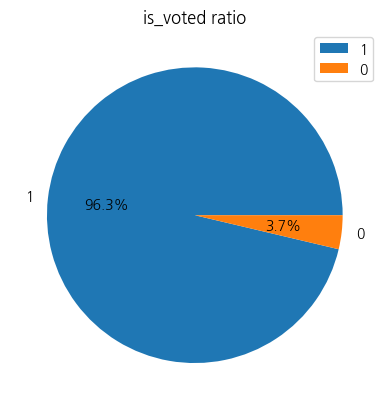

In [39]:
# polls_questionpiece -> is_voted 비율
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(is_voted['count'], labels=is_voted['is_voted'], autopct='%1.1f%%',)
ax.legend()
plt.title('is_voted ratio')
plt.show()

In [ ]:
is_skipped = polls_questionpiece['is_skipped'].value_counts().reset_index()

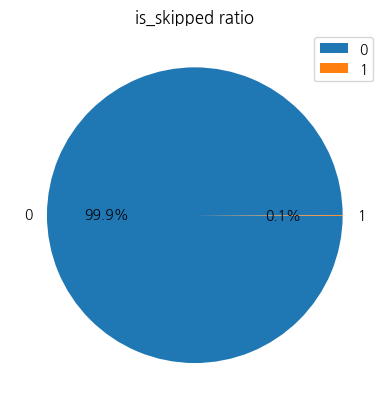

In [40]:
# polls_questionpiece -> is_skipped 비율
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(is_skipped['count'], labels=is_skipped['is_skipped'], autopct='%1.1f%%',)
ax.legend()
plt.title('is_skipped ratio')
plt.show()

In [ ]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionset.parquet"
polls_questionset = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [37]:
poll_status = polls_questionset['status'].value_counts().reset_index()
poll_status

,status,count
0,F,153411
1,O,4407
2,C,566


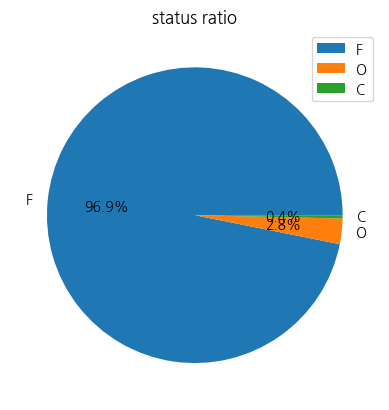

In [42]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.pie(poll_status['count'], labels=poll_status['status'], autopct='%1.1f%%',)
ax.legend()
plt.title('status ratio')
plt.show()

In [44]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/polls_questionset.parquet"
polls_questionset = pd.read_parquet(gcs_parquet_path, engine='pyarrow').drop(columns='id')

In [ ]:
polls_questionset['created_at']

,question_piece_id_list,opening_time,status,created_at,user_id
0,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477
...,...,...,...,...,...
158379,"[208383291, 208383292, 208383293, 208383294, 2...",2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933
158380,"[208384201, 208384202, 208384203, 208384204, 2...",2024-05-06 11:38:20,C,2024-05-06 10:58:20,876072
158381,"[208384951, 208384952, 208384953, 208384954, 2...",2024-05-07 00:55:00,C,2024-05-07 00:15:00,1208878
158382,"[208385211, 208385212, 208385213, 208385214, 2...",2024-05-07 12:09:08,C,2024-05-07 11:29:08,1001607


In [47]:
created_at = polls_questionset['created_at'].value_counts().reset_index()

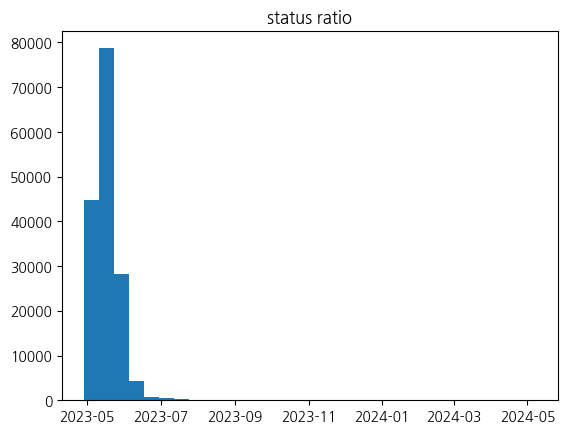

In [54]:
fig, ax = plt.subplots()
# fig.patch.set_facecolor('none')
ax.hist(polls_questionset['created_at'], bins=30)
plt.title('status ratio')
plt.show()

In [55]:
polls_questionset['created_at']

0        2023-04-28 12:27:23
1        2023-04-28 12:28:07
2        2023-04-28 12:28:38
3        2023-04-28 12:28:38
4        2023-04-28 12:28:57
                 ...        
158379   2024-05-05 14:06:27
158380   2024-05-06 10:58:20
158381   2024-05-07 00:15:00
158382   2024-05-07 11:29:08
158383   2024-05-07 11:32:30
Name: created_at, Length: 158384, dtype: datetime64[ns]

## 분석 준비

### hackle 전처리 확인

In [3]:
gcs_parquet_path = "gs://sprintda05_final_project/hackle/hackle_events.parquet"
hackle_events = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [4]:
hackle_events.columns

Index(['event_id', 'event_datetime', 'event_key', 'session_id', 'id',
       'item_name', 'page_name', 'friend_count', 'votes_count',
       'heart_balance', 'question_id'],
      dtype='object')

In [13]:
print(hackle_events[hackle_events['event_key']=='button']['event_id'].count())
print(hackle_events[hackle_events['event_key']=='click_appbar_setting']['event_id'].count())
print(hackle_events['event_id'].count())

428
26685
11441319


In [ ]:
hackle_events['event_id'] == hackle_events['id']

### accounts_user 전처리 확인

In [15]:
gcs_parquet_path = "gs://sprintda05_final_project/processed/accounts_user_processed.parquet"
accounts_user_processed = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [18]:
accounts_user_processed['id'].astype('int')

0          831956
1          831962
2          832151
3          832340
4          832520
           ...   
677080    1583729
677081    1583730
677082    1583731
677083    1583732
677084    1583733
Name: id, Length: 677085, dtype: int64

### accounts_user_contact 테이블 네트워크 이론 적용

In [2]:
gcs_parquet_path = "gs://sprintda05_final_project/votes/accounts_user_contacts.parquet"
accounts_user_contacts = pd.read_parquet(gcs_parquet_path, engine='pyarrow')

In [3]:
accounts_user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


## 초기 분석

In [1]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from google.cloud import storage
import gcsfs
from collections import defaultdict

### 0. 파일 세팅

#### 바로 불러와서 merge (kernel crush 이슈 있음)

In [ ]:
# GCS 버킷 내 모든 parquet 파일 가져오기
fs = gcsfs.GCSFileSystem()
parquet_paths = fs.glob("sprintda05_final_project/**/*.parquet")

# 1. 전처리 파일 우선 선택
file_map = defaultdict(list)
for path in parquet_paths:
    filename = path.split("/")[-1].replace(".parquet", "")
    base_name = filename.replace("_processed", "")
    file_map[base_name].append((filename, path))

final_paths = []
for base_name, files in file_map.items():
    processed = [p for f, p in files if f.endswith("_processed")]
    if processed:
        final_paths.append(processed[0])
    else:
        final_paths.append(files[0][1])

# 2. 병합 준비
dataframes = {}
merged_df = pd.DataFrame()

# 3. accounts_user 불러오기
accounts_path = "gs://sprintda05_final_project/processed/accounts_user_processed.parquet"
accounts_df = pd.read_parquet(accounts_path, engine="pyarrow")
merged_df = accounts_df.copy().rename(columns={"id": "user_id"})
dataframes["accounts_user"] = accounts_df

# 4. 나머지 테이블 병합
for path in final_paths:
    try:
        df = pd.read_parquet(f"gs://{path}", engine="pyarrow")
    except Exception as e:
        print(f"❌ Failed to read {path}: {e}")
        continue

    filename = path.split("/")[-1].replace(".parquet", "")

    if filename == "accounts_user":
        continue

    # hackle로 시작하는 테이블은 스킵
    if filename.startswith("hackle"):
        print(f"✅ Skipped {filename}: hackle table")
        continue

    # user_id 없는 테이블은 스킵
    if "user_id" not in df.columns:
        print(f"✅ Skipped {filename}: no 'user_id' column")
        continue

    # user_id 형식 통일
    if not pd.api.types.is_integer_dtype(df['user_id']):
        df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce').astype('Int64')

    # 병합
    merged_df = merged_df.merge(
        df,
        on="user_id",
        how="outer",
        suffixes=("", f"_{filename}")
    )

    dataframes[filename] = df

#### 미친 코드 (백업용)

In [ ]:
# GCS에서 Parquet 파일 불러오기 (hackle 관련 데이터)
hackle_events = pd.read_parquet("gs://sprintda05_final_project/processed/hackle_events_processed.parquet", engine='pyarrow')
hackle_device_properties = pd.read_parquet("gs://sprintda05_final_project/hackle/device_properties.parquet", engine='pyarrow')
hackle_user_properties = pd.read_parquet("gs://sprintda05_final_project/hackle/user_properties.parquet", engine='pyarrow')
hackle_properties = pd.read_parquet("gs://sprintda05_final_project/hackle/hackle_properties.parquet", engine='pyarrow')

# 저장할 디렉토리 경로
save_directory = "/home/jovyan/work/data"

# 디렉토리가 존재하지 않으면 생성
os.makedirs(save_directory, exist_ok=True)

# CSV 파일로 저장
hackle_events.to_csv(os.path.join(save_directory, "hackle_events_processed.csv"), index=False)
hackle_device_properties.to_csv(os.path.join(save_directory, "hackle_device_properties.csv"), index=False)
hackle_user_properties.to_csv(os.path.join(save_directory, "hackle_user_properties.csv"), index=False)
hackle_properties.to_csv(os.path.join(save_directory, "hackle_properties.csv"), index=False)

print("모든 파일이 성공적으로 CSV로 저장되었습니다:")
print(f"- hackle_events_processed.csv")
print(f"- hackle_device_properties.csv") 
print(f"- hackle_user_properties.csv")
print(f"- hackle_properties.csv")
print(f"저장 위치: {save_directory}")

In [ ]:
# GCS에서 Parquet 파일 불러오기 (votes 관련 데이터)
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_group = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_group.parquet", engine='pyarrow')
accounts_nearbyschool = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_user_contacts = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_user_contacts.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_school = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_school.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
accounts_userwithdraw = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
events = pd.read_parquet("gs://sprintda05_final_project/votes/events.parquet", engine='pyarrow')
polls_question = pd.read_parquet("gs://sprintda05_final_project/votes/polls_question.parquet", engine='pyarrow')
polls_questionpiece = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionpiece.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')
polls_usercandidate = pd.read_parquet("gs://sprintda05_final_project/votes/polls_usercandidate.parquet", engine='pyarrow')

# 저장할 디렉토리 경로
save_directory = "/home/jovyan/work/data"

# 디렉토리가 존재하지 않으면 생성
os.makedirs(save_directory, exist_ok=True)

# CSV 파일로 저장
accounts_attendance.to_csv(os.path.join(save_directory, "accounts_attendance.csv"), index=False)
accounts_blockrecord.to_csv(os.path.join(save_directory, "accounts_blockrecord_processed.csv"), index=False)
accounts_failpaymenthistory.to_csv(os.path.join(save_directory, "accounts_failpaymenthistory.csv"), index=False)
accounts_friendrequest.to_csv(os.path.join(save_directory, "accounts_friendrequest.csv"), index=False)
accounts_group.to_csv(os.path.join(save_directory, "accounts_group.csv"), index=False)
accounts_nearbyschool.to_csv(os.path.join(save_directory, "accounts_nearbyschool.csv"), index=False)
accounts_paymenthistory.to_csv(os.path.join(save_directory, "accounts_paymenthistory.csv"), index=False)
accounts_user_contacts.to_csv(os.path.join(save_directory, "accounts_user_contacts.csv"), index=False)
accounts_pointhistory.to_csv(os.path.join(save_directory, "accounts_pointhistory.csv"), index=False)
accounts_school.to_csv(os.path.join(save_directory, "accounts_school.csv"), index=False)
accounts_timelinereport.to_csv(os.path.join(save_directory, "accounts_timelinereport.csv"), index=False)
accounts_user.to_csv(os.path.join(save_directory, "accounts_user_processed.csv"), index=False)
accounts_userquestionrecord.to_csv(os.path.join(save_directory, "accounts_userquestionrecord_processed.csv"), index=False)
accounts_userwithdraw.to_csv(os.path.join(save_directory, "accounts_userwithdraw.csv"), index=False)
event_receipts.to_csv(os.path.join(save_directory, "event_receipts.csv"), index=False)
events.to_csv(os.path.join(save_directory, "events.csv"), index=False)
polls_question.to_csv(os.path.join(save_directory, "polls_question.csv"), index=False)
polls_questionpiece.to_csv(os.path.join(save_directory, "polls_questionpiece.csv"), index=False)
polls_questionreport.to_csv(os.path.join(save_directory, "polls_questionreport.csv"), index=False)
polls_questionset.to_csv(os.path.join(save_directory, "polls_questionset.csv"), index=False)
polls_usercandidate.to_csv(os.path.join(save_directory, "polls_usercandidate.csv"), index=False)

print("모든 votes 관련 파일이 성공적으로 CSV로 저장되었습니다:")
print("- accounts_attendance.csv")
print("- accounts_blockrecord_processed.csv")
print("- accounts_failpaymenthistory.csv")
print("- accounts_friendrequest.csv")
print("- accounts_group.csv")
print("- accounts_nearbyschool.csv")
print("- accounts_paymenthistory.csv")
print("- accounts_user_contacts.csv")
print("- accounts_pointhistory.csv")
print("- accounts_school.csv")
print("- accounts_timelinereport.csv")
print("- accounts_user_processed.csv")
print("- accounts_userquestionrecord_processed.csv")
print("- accounts_userwithdraw.csv")
print("- event_receipts.csv")
print("- events.csv")
print("- polls_question.csv")
print("- polls_questionpiece.csv")
print("- polls_questionreport.csv")
print("- polls_questionset.csv")
print("- polls_usercandidate.csv")
print(f"\n총 21개 파일이 저장되었습니다.")
print(f"저장 위치: {save_directory}")

#### 백업 파일 merge

In [2]:
data_folder = "/home/jovyan/work/data"
files = [f for f in os.listdir(data_folder) if (f != 'accounts_user_processed.csv') & (f.endswith('.csv'))]

# user_id 리스트 기준: accounts_user_processed.csv
user_df = pd.read_csv(os.path.join(data_folder, "accounts_user_processed.csv")).rename(columns={"id": "user_id"})
user_df['created_at'] = pd.to_datetime(user_df['created_at'].astype(str), format='ISO8601', errors='coerce')

# user_df의 created_at도 비교에 포함되도록 full_df에 추가
user_df_for_merge = user_df[['user_id', 'created_at']].copy()
user_df_for_merge['table'] = 'accounts_user_processed'

# 모든 created_at 정보를 담을 리스트
all_records = [user_df_for_merge]  # 여기에 먼저 추가

for filename in files:
    if filename.startswith("hackle"):
        print(f"✅ Skipped {filename}: hackle table")
        continue

    filepath = os.path.join(data_folder, filename)
    try:
        df = pd.read_csv(filepath, usecols=['user_id', 'created_at'])
    except (ValueError, FileNotFoundError):
        print(f"✅ Skipped {filename}: required columns missing or unreadable")
        continue

    df = df.dropna(subset=['user_id', 'created_at'])  # 결측값 제거
    df['created_at'] = pd.to_datetime(df['created_at'].astype(str), format='ISO8601', errors='coerce')  # 날짜 변환
    df = df.dropna(subset=['created_at'])  # 변환 실패 제거
    df['table'] = os.path.splitext(filename)[0]  # 출처 테이블명 추가

    all_records.append(df[['user_id', 'created_at', 'table']])

# 하나의 DataFrame으로 결합
full_df = pd.concat(all_records, ignore_index=True)

# 각 user_id별로 가장 이른/늦은 created_at과 출처 테이블 찾기
agg_df = full_df.sort_values(['user_id', 'created_at']).groupby('user_id').agg(
    first_created_at=('created_at', 'first'),
    last_created_at=('created_at', 'last')
).reset_index()

# 각각의 출처 테이블 찾기
first_table_df = full_df.sort_values(['user_id', 'created_at']).drop_duplicates('user_id', keep='first')[['user_id', 'table']].rename(columns={'table': 'first_created_at_table'})
last_table_df = full_df.sort_values(['user_id', 'created_at']).drop_duplicates('user_id', keep='last')[['user_id', 'table']].rename(columns={'table': 'last_created_at_table'})

# 최종 병합
merged_df = user_df[['user_id']].merge(agg_df, on='user_id', how='left') \
                             .merge(first_table_df, on='user_id', how='left') \
                             .merge(last_table_df, on='user_id', how='left')

merged_df['duration'] = merged_df['last_created_at'] - merged_df['first_created_at']

print(merged_df.head())

✅ Skipped accounts_attendance.csv: required columns missing or unreadable
✅ Skipped hackle_user_properties.csv: hackle table
✅ Skipped accounts_user_contacts.csv: required columns missing or unreadable
✅ Skipped accounts_friendrequest.csv: required columns missing or unreadable
✅ Skipped hackle_device_properties.csv: hackle table
✅ Skipped accounts_userwithdraw.csv: required columns missing or unreadable
✅ Skipped hackle_events_processed.csv: hackle table
✅ Skipped polls_question.csv: required columns missing or unreadable
✅ Skipped accounts_school.csv: required columns missing or unreadable
✅ Skipped accounts_nearbyschool.csv: required columns missing or unreadable
✅ Skipped events.csv: required columns missing or unreadable
✅ Skipped accounts_group.csv: required columns missing or unreadable
✅ Skipped polls_questionpiece.csv: required columns missing or unreadable
✅ Skipped hackle_properties.csv: hackle table
   user_id           first_created_at            last_created_at  \
0   831

#### 호재 버전 merge (참고용)

In [ ]:
# 데이터 디렉토리
data_dir = "/home/jovyan/work/data"

all_data = []

# 각 테이블에서 데이터 추출
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # id가 user_id 역할
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# 일반 테이블들 처리
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# 친구 요청 테이블 - 보낸 사람만 포함 (능동적 활동)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 보낸 사람만 (능동적 활동)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# 모든 데이터 병합
merged_df = pd.concat(all_data, ignore_index=True)

# created_at을 datetime으로 변환
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null 값 제거
merged_df = merged_df.dropna(subset=['created_at'])

# user_id로 그룹화하고 created_at으로 정렬
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"총 {len(merged_df):,}개 레코드 병합 완료")
print(f"유니크 사용자 수: {merged_df['user_id'].nunique():,}")
print("\n테이블별 레코드 수:")
print(merged_df['table_name'].value_counts())

### 1. 유행 현상 해부

#### 2023년 5월 가입자가 전체의 몇 %?

In [ ]:
year_2023 = merged_df['first_created_at'].dt.year == 2023
month_5 = merged_df['first_created_at'].dt.month == 5
print(f"{round((len(merged_df[year_2023 & month_5]) * 100 / len(merged_df)),2)}%")

93.86%


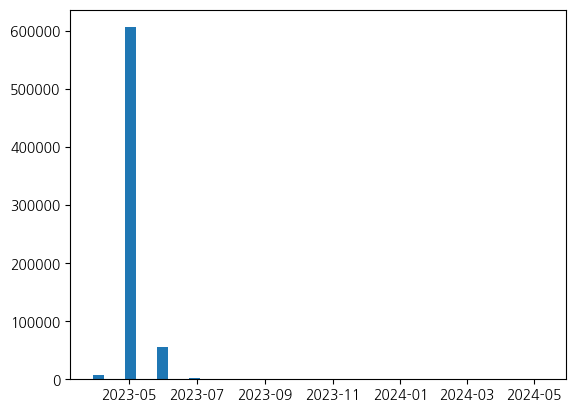

In [58]:
fig, ax = plt.subplots()
ax.hist(merged_df['first_created_at'], width=10, bins=14)
plt.show()

#### 2023년 3,4월 대비 5월 가입자 비율

In [62]:
year_2023 = merged_df['first_created_at'].dt.year == 2023
month_34 = merged_df['first_created_at'].dt.month <=4
print(f"{round(len(merged_df[year_2023 & month_5]) * 100 / len(merged_df[year_2023 & month_34]),2)}%")

3328.47%


### 2. 서비스 확산 패턴 확인

- '시작_학교': '어느 학교에서 시작?’
- '확산_순서': '학교 A → B → C 순서’
- '확산_속도': '학교간 전파 소요 일수’
- '지리적_관계': '가까운 학교끼리 퍼졌나?’
- 사용자의 가입 시기별 학교 위치

#### 학교/친구 파일 세팅

In [5]:
accounts_user = pd.read_csv('/home/jovyan/work/data/accounts_user_processed.csv').rename(columns={'id':'user_id'})
accounts_group = pd.read_csv('/home/jovyan/work/data/accounts_group.csv')
accounts_school = pd.read_csv('/home/jovyan/work/data/accounts_school.csv', encoding='UTF-8')
user = pd.merge(merged_df, accounts_user[['user_id','gender','group_id','friend_id_list','friend_count']], on='user_id')
user = pd.merge(user, accounts_group, left_on='group_id', right_on='id')
user = pd.merge(user, accounts_school, left_on='school_id', right_on='id')

In [105]:
user.head(1)

,user_id,first_created_at,last_created_at,first_created_at_table,last_created_at_table,duration,gender,group_id,friend_id_list,friend_count,id_x,grade,class_num,school_id,id_y,address,student_count,school_type
0,833024,2023-03-31 09:05:51.903699,2023-03-31 09:05:51.903699,accounts_user_processed,accounts_user_processed,0 days,F,35.0,"[1313154, 1242755, 1435789, 1365775, 1354259, ...",41,35,1,10,5464,5464,경기도 군포시,158,H


#### 학교별 최초 가입 시점 및 순서

In [ ]:
user_df = pd.read_csv("/home/jovyan/work/data/user.csv", parse_dates=["first_created_at"])
school_first_join = user_df.groupby("school_id")["first_created_at"].min().reset_index()
school_first_join = school_first_join.sort_values("first_created_at").reset_index(drop=True)
school_first_join["diffusion_order"] = school_first_join.index + 1

In [ ]:
school_first_join_top20 = school_first_join.sort_values("diffusion_order", ascending=False)[:20]
school_first_join_top20.plot(kind='barh', title='가입 시점 빠른 학교 top20', figsize=(8, 6))
plt.show()

#### 학교 간 확산 속도 (소요 일수)

In [ ]:
school_first_join["diffusion_speed"] = school_first_join["first_created_at"].diff().dt.days.fillna(0).astype(int)

In [ ]:
school_high_diffusion_top20 = school_first_join.sort_values("diffusion_speed", ascending=False)[:20]
school_high_diffusion_top20.plot(kind='barh', title='전파 속도 빠른 학교 top20', figsize=(8, 6))
plt.show()

#### 지리적 인접성 확인

In [ ]:
nearby_df = pd.read_csv("/home/jovyan/work/data/accounts_nearbyschool.csv")

# 학교 간 확산 순서를 nearby 관계와 비교하여 인접 전파 여부 파악
school_first_join["former_school"] = school_first_join["school_id"].shift(1)
school_first_join["nearby_diffusion"] = school_first_join.apply(
    lambda row: ((row["former_school"], row["school_id"]) in set(zip(nearby_df["school_id"], nearby_df["nearby_school_id"]))),
    axis=1
)

#### 시간대별 가입자 급증 파악

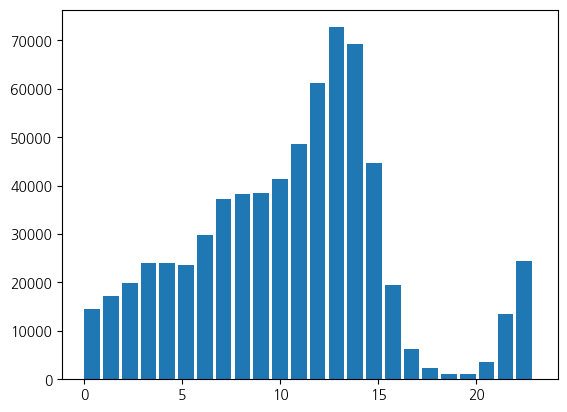

In [50]:
fig, ax = plt.subplots()
ax.hist(merged_df['first_created_at'].dt.hour, width=0.8, bins=24)
plt.show()

최고의 히트는 점심시간

#### 초기 사용자 영향력

In [ ]:
# 친구 수 기준 상위 유저 선별 (Top 1% or top N)
top_users = user_df.sort_values("friend_count", ascending=False).head(50)

# 이들의 소속 학교 및 가입 시점 이후 그 학교 가입률 변화 분석
impact_analysis = []

for _, user in top_users.iterrows():
    school_id = user["school_id"]
    join_time = user["first_created_at"]

    # 같은 학교 가입자 중 해당 시점 전/후 비교
    before = user_df[(user_df["school_id"] == school_id) & (user_df["first_created_at"] < join_time)]
    after = user_df[(user_df["school_id"] == school_id) & (user_df["first_created_at"] > join_time)]

    impact_analysis.append({
        "user_id": user["user_id"],
        "school_id": school_id,
        "가입_이후_증가": len(after),
        "가입_이전": len(before),
        "증가율": len(after) / (len(before) + 1)
    })

impact_df = pd.DataFrame(impact_analysis)

#### 확산 네트워크 분석

전체코드 + 지역 네트워크 시각화

총 사용자 수: 676987
총 학교 수: 5550
총 지역 수: 251

=== 서비스 시작점 분석 ===
초기 사용자 기준 날짜: 2023-04-26 08:14:18.848285696
초기 사용자 수: 6770

초기 확산 학교 TOP 10:
  학교 ID 2062: 400명
  학교 ID 2043: 307명
  학교 ID 2079: 298명
  학교 ID 2048: 294명
  학교 ID 2545: 265명
  학교 ID 2078: 225명
  학교 ID 2075: 223명
  학교 ID 323: 187명
  학교 ID 2041: 182명
  학교 ID 2071: 152명

초기 확산 지역 TOP 10:
  서울특별시 송파구: 3113명
  서울특별시 강동구: 651명
  충청남도 천안시: 518명
  서울특별시 강남구: 489명
  경기도 남양주시: 286명
  경기도 성남시: 232명
  경기도 하남시: 165명
  서울특별시 성동구: 126명
  전라남도 나주시: 104명
  서울특별시 노원구: 82명

=== 확산 순서 분석 ===
학교별 확산 순서 (첫 10개):
  5112. 학교 ID 5464: 2023-03-31
  284. 학교 ID 314: 2023-03-31
  252. 학교 ID 281: 2023-03-31
  244. 학교 ID 272: 2023-03-31
  260. 학교 ID 289: 2023-03-31
  4201. 학교 ID 4523: 2023-04-01
  241. 학교 ID 268: 2023-04-01
  4401. 학교 ID 4732: 2023-04-01
  7. 학교 ID 10: 2023-04-04
  2741. 학교 ID 2932: 2023-04-04

지역별 확산 순서 (첫 10개):
  30. 경기도 군포시: 2023-03-31
  237. 충청남도 천안시: 2023-03-31
  54. 경기도 화성시: 2023-04-01
  47. 경기도 의왕시: 2023-04-01
  251. 충청북도 충주시: 2023-04

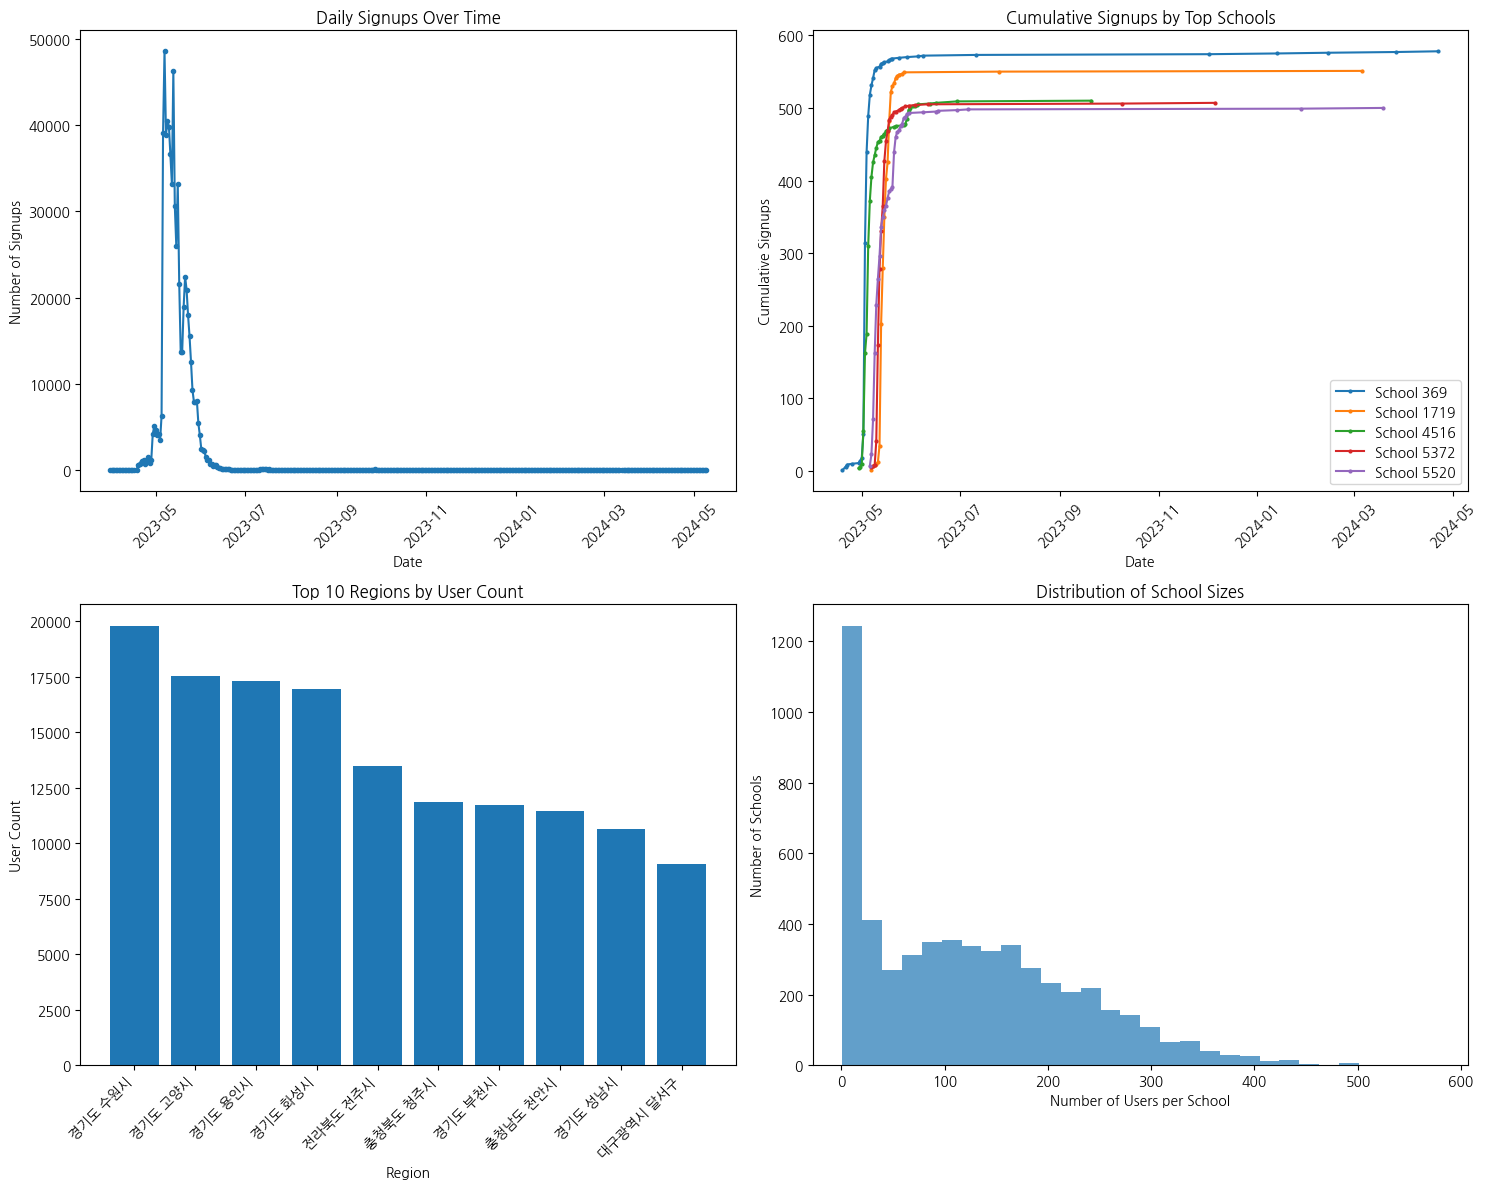

TypeError: draw_networkx_nodes() got an unexpected keyword argument 'font_family'

<Figure size 1200x800 with 0 Axes>

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from collections import defaultdict, Counter
import koreanize_matplotlib

font_path = "/home/jovyan/work/data/nanum-gothic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_prop)
mpl.rcParams['axes.unicode_minus'] = False

class SNSDiffusionAnalyzer:
    def __init__(self, nearby_school_data_path=None):
        """
        SNS 확산 분석기 초기화
        
        Args:
            user_data_path: 사용자 데이터 파일 경로
            nearby_school_data_path: 근처 학교 데이터 파일 경로 (선택사항)
        """
        self.user_df = user
        self.nearby_df = pd.read_csv(nearby_school_data_path) if nearby_school_data_path else None
        
        # 데이터 전처리
        self._preprocess_data()
        
        # 네트워크 그래프들
        self.school_network = nx.Graph()
        self.region_network = nx.Graph()
        self.class_network = nx.Graph()
        
    def _preprocess_data(self):
        """데이터 전처리"""
        # 날짜 형식 변환
        self.user_df['first_created_at'] = pd.to_datetime(self.user_df['first_created_at'])
        self.user_df['last_created_at'] = pd.to_datetime(self.user_df['last_created_at'])
        
        # 친구 리스트 파싱 (문자열을 리스트로 변환)
        self.user_df['friend_id_list'] = self.user_df['friend_id_list'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else []
        )
        
        # 지역 정보 추출 (시/군/구까지)
        self.user_df['region'] = self.user_df['address'].apply(
            lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
        )
        
        # 학교-학급 조합 생성
        self.user_df['school_class'] = self.user_df['school_id'].astype(str) + '_' + \
                                      self.user_df['grade'].astype(str) + '_' + \
                                      self.user_df['class_num'].astype(str)
        
        print(f"총 사용자 수: {len(self.user_df)}")
        print(f"총 학교 수: {self.user_df['school_id'].nunique()}")
        print(f"총 지역 수: {self.user_df['region'].nunique()}")
        
    def analyze_diffusion_start(self):
        """서비스 시작점 분석"""
        print("\n=== 서비스 시작점 분석 ===")
        
        # 가장 먼저 가입한 사용자들 (상위 1%)
        early_threshold = self.user_df['first_created_at'].quantile(0.01)
        early_users = self.user_df[self.user_df['first_created_at'] <= early_threshold]
        
        print(f"초기 사용자 기준 날짜: {early_threshold}")
        print(f"초기 사용자 수: {len(early_users)}")
        
        # 초기 사용자들의 학교/지역 분포
        start_schools = early_users['school_id'].value_counts().head(10)
        start_regions = early_users['region'].value_counts().head(10)
        
        print("\n초기 확산 학교 TOP 10:")
        for school_id, count in start_schools.items():
            print(f"  학교 ID {school_id}: {count}명")
            
        print("\n초기 확산 지역 TOP 10:")
        for region, count in start_regions.items():
            print(f"  {region}: {count}명")
            
        return early_users, start_schools, start_regions
    
    def analyze_diffusion_order(self):
        """확산 순서 분석"""
        print("\n=== 확산 순서 분석 ===")
        
        # 학교별 첫 사용자 가입 시점
        school_first_user = self.user_df.groupby('school_id')['first_created_at'].min().reset_index()
        school_first_user = school_first_user.sort_values('first_created_at')
        
        # 지역별 첫 사용자 가입 시점
        region_first_user = self.user_df.groupby('region')['first_created_at'].min().reset_index()
        region_first_user = region_first_user.sort_values('first_created_at')
        
        print("학교별 확산 순서 (첫 10개):")
        for i, row in school_first_user.head(10).iterrows():
            print(f"  {i+1}. 학교 ID {row['school_id']}: {row['first_created_at'].strftime('%Y-%m-%d')}")
            
        print("\n지역별 확산 순서 (첫 10개):")
        for i, row in region_first_user.head(10).iterrows():
            print(f"  {i+1}. {row['region']}: {row['first_created_at'].strftime('%Y-%m-%d')}")
            
        return school_first_user, region_first_user
    
    def analyze_diffusion_speed(self):
        """확산 속도 분석"""
        print("\n=== 확산 속도 분석 ===")
        
        # 학교별 첫 사용자와 100번째 사용자 간의 시간차
        school_speeds = []
        
        for school_id in self.user_df['school_id'].unique():
            school_users = self.user_df[self.user_df['school_id'] == school_id].sort_values('first_created_at')
            
            if len(school_users) >= 10:  # 최소 10명 이상인 학교만
                first_user_date = school_users.iloc[0]['first_created_at']
                tenth_user_date = school_users.iloc[9]['first_created_at']  # 10번째 사용자
                
                speed_days = (tenth_user_date - first_user_date).days
                
                school_speeds.append({
                    'school_id': school_id,
                    'first_date': first_user_date,
                    'tenth_date': tenth_user_date,
                    'speed_days': speed_days,
                    'total_users': len(school_users)
                })
        
        speed_df = pd.DataFrame(school_speeds)
        speed_df = speed_df.sort_values('speed_days')
        
        print("학교내 확산 속도 TOP 10 (빠른 순):")
        for _, row in speed_df.head(10).iterrows():
            print(f"  학교 ID {row['school_id']}: {row['speed_days']}일 "
                  f"(총 {row['total_users']}명)")
            
        return speed_df
    
    def build_region_network(self):
        """지역 간 네트워크 구축"""
        print("\n=== 지역 네트워크 구축 ===")
        
        # 지역별 사용자 매핑
        region_users = defaultdict(list)
        for _, user in self.user_df.iterrows():
            region_users[user['region']].append(user['user_id'])
        
        # 지역 간 친구 관계 카운트
        region_connections = defaultdict(int)
        
        for _, user in self.user_df.iterrows():
            user_region = user['region']
            friends = user['friend_id_list']
            
            for friend_id in friends:
                friend_info = self.user_df[self.user_df['user_id'] == friend_id]
                if not friend_info.empty:
                    friend_region = friend_info.iloc[0]['region']
                    if user_region != friend_region:
                        region_pair = tuple(sorted([user_region, friend_region]))
                        region_connections[region_pair] += 1
        
        # 네트워크 그래프 구축
        for (region1, region2), weight in region_connections.items():
            if weight >= 5:  # 최소 5개 이상의 친구 관계
                self.region_network.add_edge(region1, region2, weight=weight)
        
        print(f"지역 노드 수: {self.region_network.number_of_nodes()}")
        print(f"지역 간 연결 수: {self.region_network.number_of_edges()}")
        
        return region_connections
    
    def build_school_network(self):
        """학교 간 네트워크 구축"""
        print("\n=== 학교 네트워크 구축 ===")
        
        # 학교별 사용자 매핑
        school_users = defaultdict(list)
        for _, user in self.user_df.iterrows():
            school_users[user['school_id']].append(user['user_id'])
        
        # 학교 간 친구 관계 카운트
        school_connections = defaultdict(int)
        
        for _, user in self.user_df.iterrows():
            user_school = user['school_id']
            friends = user['friend_id_list']
            
            for friend_id in friends:
                friend_info = self.user_df[self.user_df['user_id'] == friend_id]
                if not friend_info.empty:
                    friend_school = friend_info.iloc[0]['school_id']
                    if user_school != friend_school:
                        school_pair = tuple(sorted([user_school, friend_school]))
                        school_connections[school_pair] += 1
        
        # 네트워크 그래프 구축
        for (school1, school2), weight in school_connections.items():
            if weight >= 3:  # 최소 3개 이상의 친구 관계
                self.school_network.add_edge(school1, school2, weight=weight)
        
        print(f"학교 노드 수: {self.school_network.number_of_nodes()}")
        print(f"학교 간 연결 수: {self.school_network.number_of_edges()}")
        
        return school_connections
    
    def analyze_geographic_relationship(self):
        """지리적 관계 분석"""
        if self.nearby_df is None:
            print("근처 학교 데이터가 없어 지리적 분석을 건너뜁니다.")
            return None
            
        print("\n=== 지리적 관계 분석 ===")
        
        # 근처 학교 간 실제 친구 관계 확인
        nearby_connections = 0
        total_connections = 0
        
        geographic_analysis = []
        
        for edge in self.school_network.edges(data=True):
            school1, school2, data = edge
            weight = data['weight']
            total_connections += weight
            
            # 두 학교가 50km 이내인지 확인
            is_nearby = False
            nearby_info = self.nearby_df[
                ((self.nearby_df['school_id'] == school1) & 
                 (self.nearby_df['nearby_school_id'] == school2)) |
                ((self.nearby_df['school_id'] == school2) & 
                 (self.nearby_df['nearby_school_id'] == school1))
            ]
            
            if not nearby_info.empty:
                is_nearby = True
                distance = nearby_info.iloc[0]['distance']
                nearby_connections += weight
            else:
                distance = None
            
            geographic_analysis.append({
                'school1': school1,
                'school2': school2,
                'connections': weight,
                'is_nearby': is_nearby,
                'distance': distance
            })
        
        geo_df = pd.DataFrame(geographic_analysis)
        
        nearby_ratio = nearby_connections / total_connections if total_connections > 0 else 0
        
        print(f"총 학교 간 연결: {total_connections}")
        print(f"근거리 학교 간 연결: {nearby_connections}")
        print(f"근거리 연결 비율: {nearby_ratio:.2%}")
        
        return geo_df
    
    def visualize_region_network(self, top_n=15):
        """상위 N개 지역 네트워크 시각화"""
        print(f"\n=== 상위 {top_n}개 지역 네트워크 시각화 ===")
        
        # 지역별 사용자 수 계산
        region_counts = self.user_df['region'].value_counts()
        top_regions = region_counts.head(top_n).index.tolist()
        
        print(f"분석 대상 지역: {', '.join(top_regions)}")
        
        # 상위 지역만 포함하는 서브그래프 생성
        region_subgraph = nx.Graph()
        
        # 상위 지역 간 친구 관계 카운트
        region_connections = defaultdict(int)
        
        for _, user in self.user_df.iterrows():
            user_region = user['region']
            if user_region not in top_regions:
                continue
                
            friends = user['friend_id_list']
            
            for friend_id in friends:
                friend_info = self.user_df[self.user_df['user_id'] == friend_id]
                if not friend_info.empty:
                    friend_region = friend_info.iloc[0]['region']
                    if friend_region in top_regions and user_region != friend_region:
                        region_pair = tuple(sorted([user_region, friend_region]))
                        region_connections[region_pair] += 1
        
        # 네트워크 구축 (최소 연결 임계값 설정)
        min_connections = 3
        for (region1, region2), weight in region_connections.items():
            if weight >= min_connections:
                region_subgraph.add_edge(region1, region2, weight=weight)
        
        # 연결되지 않은 상위 지역들도 노드로 추가
        for region in top_regions:
            if region not in region_subgraph.nodes():
                region_subgraph.add_node(region)
        
        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # 1. 네트워크 그래프
        if region_subgraph.number_of_nodes() > 0:
            # 레이아웃 설정
            pos = nx.spring_layout(region_subgraph, k=3, iterations=50, seed=42)
            
            # 노드 크기: 지역별 사용자 수에 비례
            node_sizes = []
            node_colors = []
            for node in region_subgraph.nodes():
                user_count = region_counts.get(node, 0)
                node_sizes.append(user_count * 2)  # 크기 조정
                # 사용자 수에 따른 색상 그라데이션
                node_colors.append(user_count)
            
            # 엣지 두께: 연결 강도에 비례
            edge_widths = []
            edge_colors = []
            for u, v in region_subgraph.edges():
                if region_subgraph.has_edge(u, v):
                    weight = region_subgraph[u][v]['weight']
                    edge_widths.append(weight * 0.1)
                    edge_colors.append(weight)
                else:
                    edge_widths.append(1)
                    edge_colors.append(1)
            
            # 네트워크 그리기
            nodes = nx.draw_networkx_nodes(
                region_subgraph, pos, 
                node_size=node_sizes, 
                node_color=node_colors,
                cmap='YlOrRd',
                alpha=0.8,
                ax=ax1
            )
            
            if region_subgraph.number_of_edges() > 0:
                edges = nx.draw_networkx_edges(
                    region_subgraph, pos, 
                    width=edge_widths, 
                    edge_color=edge_colors,
                    edge_cmap='Blues',
                    alpha=0.6,
                    ax=ax1
                )
            
            # 라벨 그리기 (지역명)
            nx.draw_networkx_labels(
                region_subgraph, pos, 
                font_size=10, 
                font_weight='bold',
                font_family=font_prop,
                ax=ax1
            )
            
            ax1.set_title(f'상위 {top_n}개 지역 간 친구 네트워크\n(노드 크기: 사용자 수, 엣지 두께: 친구 관계 수)', fontsize=14, pad=20)
            ax1.axis('off')
            
            # 컬러바 추가
            if len(node_colors) > 0:
                plt.colorbar(nodes, ax=ax1, label='사용자 수', shrink=0.8)
        
        # 2. 지역별 사용자 수 막대 그래프
        top_region_counts = region_counts.head(top_n)
        bars = ax2.bar(range(len(top_region_counts)), top_region_counts.values, 
                      color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1)
        
        ax2.set_title(f'상위 {top_n}개 지역별 사용자 수', fontsize=14, pad=20)
        ax2.set_xlabel('지역', fontsize=12)
        ax2.set_ylabel('사용자 수', fontsize=12)
        ax2.set_xticks(range(len(top_region_counts)))
        ax2.set_xticklabels(top_region_counts.index, rotation=45, ha='right')
        
        # 막대 위에 수치 표시
        for i, (bar, value) in enumerate(zip(bars, top_region_counts.values)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
        
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 연결 통계 출력
        print(f"\n📊 지역 네트워크 통계:")
        print(f"  • 전체 지역 수: {len(top_regions)}")
        print(f"  • 연결된 지역 수: {region_subgraph.number_of_nodes()}")
        print(f"  • 지역 간 연결 수: {region_subgraph.number_of_edges()}")
        
        if region_connections:
            print(f"\n🔗 주요 지역 간 연결 (상위 10개):")
            sorted_connections = sorted(region_connections.items(), key=lambda x: x[1], reverse=True)
            for i, ((region1, region2), count) in enumerate(sorted_connections[:10]):
                print(f"  {i+1:2d}. {region1} ↔ {region2}: {count:,}개 친구 관계")
        
        return region_subgraph, region_connections
    
    def visualize_diffusion_timeline(self):
        """확산 타임라인 시각화"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. 일별 가입자 수
        daily_signups = self.user_df.groupby(self.user_df['first_created_at'].dt.date).size()
        axes[0,0].plot(daily_signups.index, daily_signups.values, marker='o', markersize=3)
        axes[0,0].set_title('Daily Signups Over Time')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel('Number of Signups')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # 2. 학교별 누적 가입자
        top_schools = self.user_df['school_id'].value_counts().head(5)
        for school_id in top_schools.index:
            school_data = self.user_df[self.user_df['school_id'] == school_id]
            daily_school = school_data.groupby(school_data['first_created_at'].dt.date).size().cumsum()
            axes[0,1].plot(daily_school.index, daily_school.values, label=f'School {school_id}', marker='o', markersize=2)
        
        axes[0,1].set_title('Cumulative Signups by Top Schools')
        axes[0,1].set_xlabel('Date')
        axes[0,1].set_ylabel('Cumulative Signups')
        axes[0,1].legend()
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # 3. 지역별 가입자 분포
        region_counts = self.user_df['region'].value_counts().head(10)
        axes[1,0].bar(range(len(region_counts)), region_counts.values)
        axes[1,0].set_title('Top 10 Regions by User Count')
        axes[1,0].set_xlabel('Region')
        axes[1,0].set_ylabel('User Count')
        axes[1,0].set_xticks(range(len(region_counts)))
        axes[1,0].set_xticklabels(region_counts.index, rotation=45, ha='right')
        
        # 4. 학교 규模별 분포
        school_sizes = self.user_df.groupby('school_id').size()
        axes[1,1].hist(school_sizes.values, bins=30, alpha=0.7)
        axes[1,1].set_title('Distribution of School Sizes')
        axes[1,1].set_xlabel('Number of Users per School')
        axes[1,1].set_ylabel('Number of Schools')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_network(self, network_type='school', top_n=20):
        """네트워크 시각화"""
        if network_type == 'school' and self.school_network.number_of_nodes() > 0:
            G = self.school_network
            title = '학교 네트워크'
        elif network_type == 'region' and self.region_network.number_of_nodes() > 0:
            G = self.region_network
            title = '지역 네트워크'
        else:
            print(f"{network_type} 네트워크가 구축되지 않았습니다.")
            return
        
        # 가장 연결이 많은 상위 N개 노드만 시각화
        degrees = dict(G.degree())
        top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:top_n]
        G_sub = G.subgraph(top_nodes)
        
        plt.figure(figsize=(12, 8))
        
        # 레이아웃 설정
        pos = nx.spring_layout(G_sub, k=1, iterations=50)
        
        # 노드 크기 설정
        node_sizes = []
        for node in G_sub.nodes():
            if network_type == 'school':
                user_count = len(self.user_df[self.user_df['school_id'] == node])
                node_sizes.append(user_count * 10)
            else:  # region
                user_count = len(self.user_df[self.user_df['region'] == node])
                node_sizes.append(user_count * 2)
        
        # 엣지 두께: 연결 강도에 비례
        edge_widths = []
        for u, v in G_sub.edges():
            weight = G_sub[u][v]['weight']
            edge_widths.append(weight * 0.5)
        
        # 그래프 그리기
        nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, alpha=0.7, node_color='lightblue')
        nx.draw_networkx_edges(G_sub, pos, width=edge_widths, alpha=0.5, edge_color='gray')
        nx.draw_networkx_labels(G_sub, pos, font_size=8, font_family=font_prop)
        
        plt.title(f'{title} (상위 {top_n}개 연결된 노드)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self):
        """종합 분석 보고서 생성"""
        print("\n" + "="*50)
        print("SNS 서비스 확산 패턴 분석 종합 보고서")
        print("="*50)
        
        # 기본 통계
        total_users = len(self.user_df)
        total_schools = self.user_df['school_id'].nunique()
        total_regions = self.user_df['region'].nunique()
        
        print(f"\n📊 기본 통계:")
        print(f"  • 총 사용자 수: {total_users:,}명")
        print(f"  • 총 학교 수: {total_schools:,}개")
        print(f"  • 총 지역 수: {total_regions:,}개")
        
        # 시간 범위
        start_date = self.user_df['first_created_at'].min()
        end_date = self.user_df['first_created_at'].max()
        duration = (end_date - start_date).days
        
        print(f"\n📅 서비스 확산 기간:")
        print(f"  • 시작일: {start_date.strftime('%Y-%m-%d')}")
        print(f"  • 종료일: {end_date.strftime('%Y-%m-%d')}")
        print(f"  • 총 기간: {duration}일")
        
        # 네트워크 통계
        if self.school_network.number_of_nodes() > 0:
            print(f"\n🌐 학교 네트워크 통계:")
            print(f"  • 연결된 학교 수: {self.school_network.number_of_nodes()}")
            print(f"  • 학교 간 연결 수: {self.school_network.number_of_edges()}")
            
            if self.school_network.number_of_nodes() > 1:
                avg_degree = sum(dict(self.school_network.degree()).values()) / self.school_network.number_of_nodes()
                print(f"  • 평균 연결도: {avg_degree:.2f}")

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # 분석기 초기화 (파일 경로는 실제 경로로 변경 필요)
    analyzer = SNSDiffusionAnalyzer(
        nearby_school_data_path='/home/jovyan/work/data/accounts_nearbyschool.csv'
    )
    
    # 1. 서비스 시작점 분석
    early_users, start_schools, start_regions = analyzer.analyze_diffusion_start()
    
    # 2. 확산 순서 분석
    school_order, region_order = analyzer.analyze_diffusion_order()
    
    # 3. 확산 속도 분석
    speed_analysis = analyzer.analyze_diffusion_speed()
    
    # 4. 네트워크 구축
    school_connections = analyzer.build_school_network()
    region_connections = analyzer.build_region_network()
    
    # 5. 지리적 관계 분석
    geo_analysis = analyzer.analyze_geographic_relationship()
    
    # 6. 시각화
    analyzer.visualize_diffusion_timeline()
    analyzer.visualize_network('school', top_n=15)
    
    # 7. 지역 네트워크 시각화
    analyzer.visualize_region_network(top_n=15)
    
    # 8. 종합 보고서
    analyzer.generate_summary_report()
    
    return analyzer

if __name__ == "__main__":
    # 실행
    analyzer = main()

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from collections import defaultdict, Counter
import koreanize_matplotlib
import pickle
import scipy

font_path = "/home/jovyan/work/data/nanum-gothic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_prop)
mpl.rcParams['axes.unicode_minus'] = False

class SNSDiffusionAnalyzer:
    def __init__(self, user_df: pd.DataFrame, nearby_school_data_path=None):
        self.user_df = user_df.copy()
        self.user_df.set_index('user_id', inplace=True)  # 🔥 핵심 최적화

        self.nearby_df = pd.read_csv(nearby_school_data_path) if nearby_school_data_path else None
        self._preprocess_data()

        self.school_network = nx.Graph()
        self.region_network = nx.Graph()

    def _preprocess_data(self):
        self.user_df['first_created_at'] = pd.to_datetime(self.user_df['first_created_at'])
        self.user_df['last_created_at'] = pd.to_datetime(self.user_df['last_created_at'])

        self.user_df['friend_id_list'] = self.user_df['friend_id_list'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else []
        )
        self.user_df['region'] = self.user_df['address'].apply(
            lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
        )

    def build_region_network(self, save_path=None):
        region_connections = {}

        for user_id, user in self.user_df.iterrows():
            user_region = user['region']
            for friend_id in user['friend_id_list']:
                if friend_id in self.user_df.index:
                    friend_region = self.user_df.loc[friend_id, 'region']
                    if user_region != friend_region:
                        pair = tuple(sorted([user_region, friend_region]))
                        region_connections[pair] = region_connections.get(pair, 0) + 1

        for (region1, region2), weight in region_connections.items():
            if weight >= 5:
                self.region_network.add_edge(region1, region2, weight=weight)

        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump(self.region_network, f)

        print(f"[지역 네트워크] 노드 수: {self.region_network.number_of_nodes()}, 엣지 수: {self.region_network.number_of_edges()}")
        return self.region_network

    def build_school_network(self, save_path=None):
        school_connections = {}

        for user_id, user in self.user_df.iterrows():
            user_school = user['school_id']
            for friend_id in user['friend_id_list']:
                if friend_id in self.user_df.index:
                    friend_school = self.user_df.loc[friend_id, 'school_id']
                    if user_school != friend_school:
                        pair = tuple(sorted([user_school, friend_school]))
                        school_connections[pair] = school_connections.get(pair, 0) + 1

        for (school1, school2), weight in school_connections.items():
            if weight >= 3:
                self.school_network.add_edge(school1, school2, weight=weight)

        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump(self.school_network, f)

        print(f"[학교 네트워크] 노드 수: {self.school_network.number_of_nodes()}, 엣지 수: {self.school_network.number_of_edges()}")
        return self.school_network

    def visualize_network(self, network: nx.Graph, title="Network", layout='spring', node_size=50, save_path=None):
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(network, seed=42) if layout == 'spring' else nx.kamada_kawai_layout(network)

        weights = [d['weight'] for _, _, d in network.edges(data=True)]
        nx.draw(network, pos, with_labels=True, node_size=node_size, width=[w * 0.1 for w in weights],
                edge_color='gray', node_color='skyblue', font_size=8, font_family=font_prop)

        plt.title(title)
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

[지역 네트워크] 노드 수: 249, 엣지 수: 15851
[학교 네트워크] 노드 수: 5347, 엣지 수: 197060


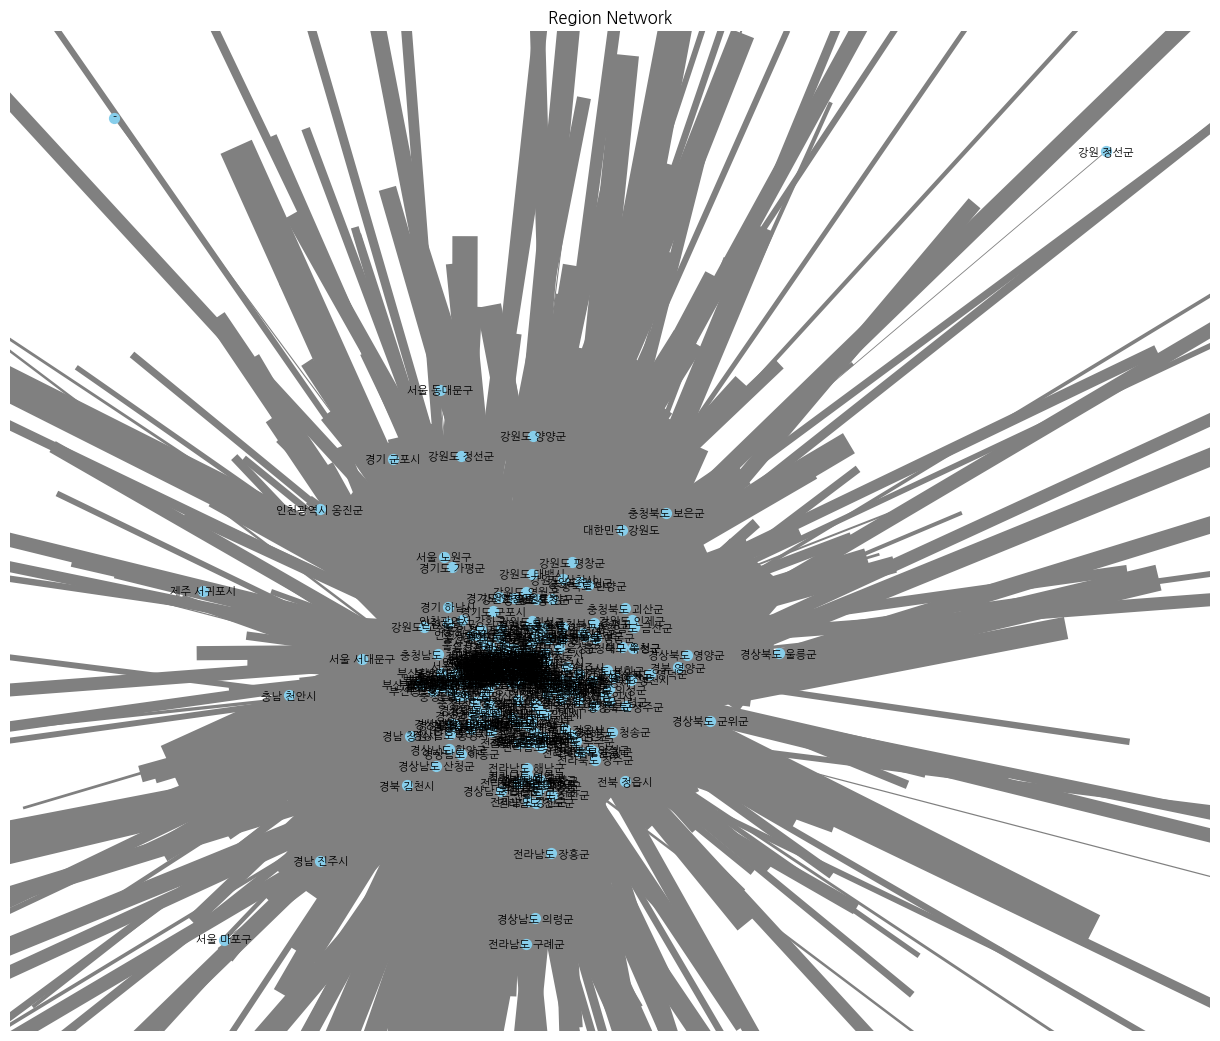

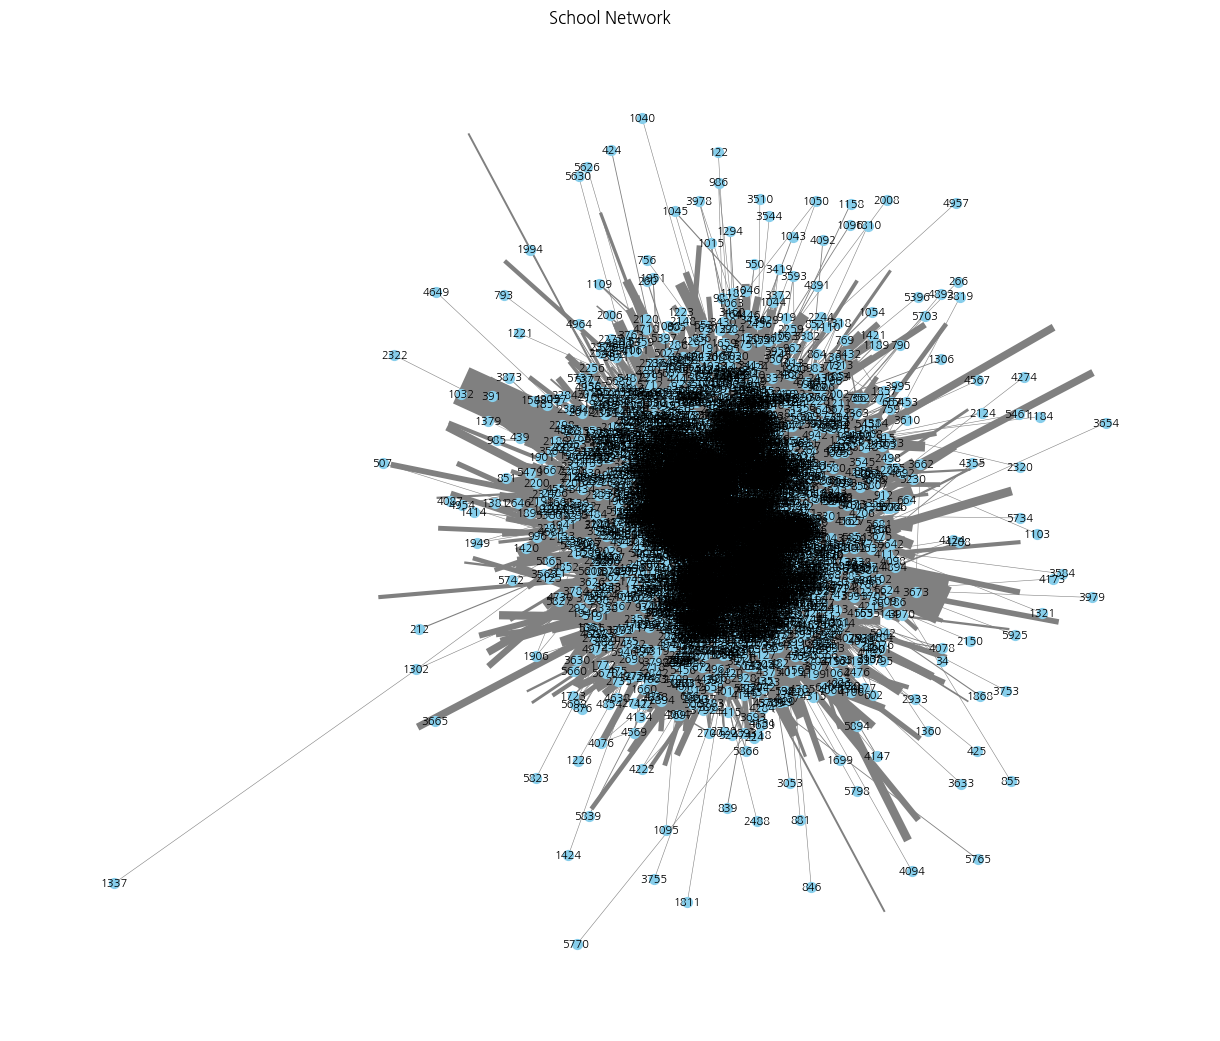

In [9]:
# 데이터프레임 user를 입력으로 사용
analyzer = SNSDiffusionAnalyzer(user)

# 네트워크 구축 및 저장
region_net = analyzer.build_region_network('region_network.pkl')
school_net = analyzer.build_school_network('school_network.pkl')

# 시각화
analyzer.visualize_network(region_net, title="Region Network", save_path="region_network.png")
analyzer.visualize_network(school_net, title="School Network", save_path="school_network.png")

지역간 네트워크 시각화

🚀 지역 네트워크 시각화 시작!
📊 데이터 로딩 중...
🔄 친구 리스트 파싱 중...
📍 총 지역 수: 251
✅ 데이터 로딩 완료 - 총 676,987명 사용자

🌐 상위 15개 지역 네트워크 구축 중...
📍 분석 대상 지역: 경기도 수원시, 경기도 고양시, 경기도 용인시, 경기도 화성시, 전라북도 전주시...
🔗 지역 간 친구 관계 분석 중...
✅ 네트워크 구축 완료 - 노드: 15, 엣지: 0
🎨 시각화 생성 중...


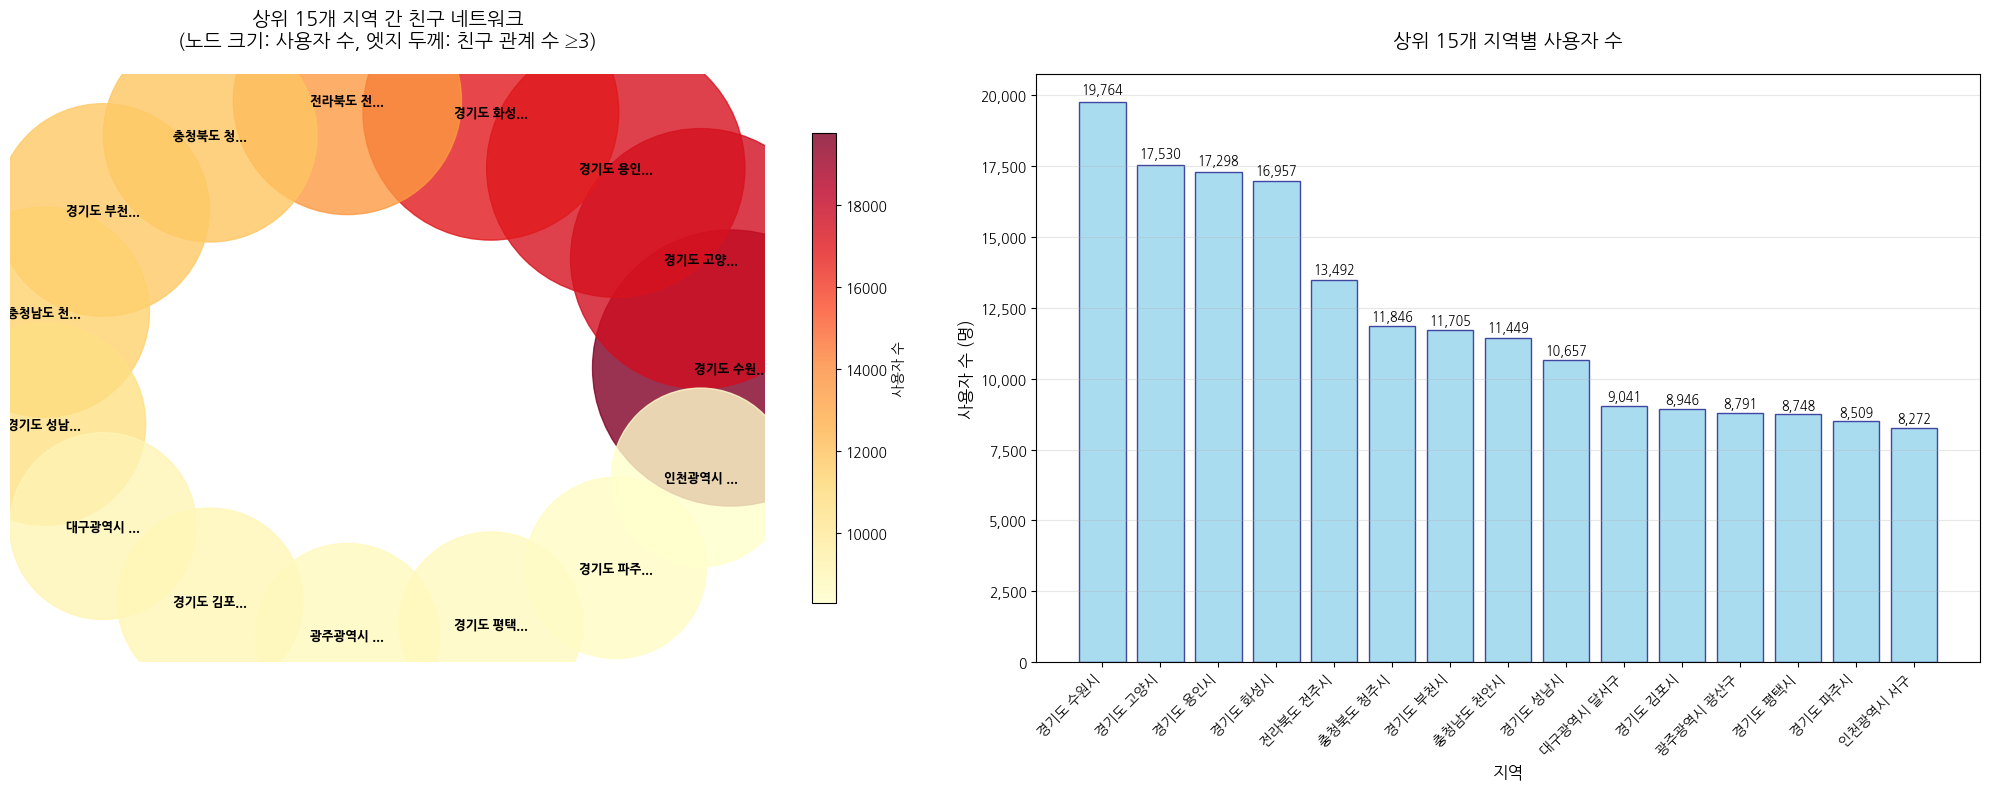


📊 지역 네트워크 분석 결과:
  • 분석 대상 지역 수: 15
  • 네트워크 노드 수: 15
  • 지역 간 연결 수: 0

🎯 네트워크 중심성 분석:
    연결된 지역이 없어 중심성 분석을 수행할 수 없습니다.

✅ 분석 완료!


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
from collections import defaultdict
import koreanize_matplotlib

font_path = "/home/jovyan/work/data/nanum-gothic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_prop)
mpl.rcParams['axes.unicode_minus'] = False

class RegionNetworkVisualizer:
    def __init__(self):
        """
        지역 네트워크 시각화 전용 클래스
        
        Args:
            user_data_path: 사용자 데이터 파일 경로
        """
        print("📊 데이터 로딩 중...")
        self.user_df = user
        self._preprocess_data()
        print(f"✅ 데이터 로딩 완료 - 총 {len(self.user_df):,}명 사용자")
        
    def _preprocess_data(self):
        """필요한 데이터만 전처리"""
        # 친구 리스트 파싱
        print("🔄 친구 리스트 파싱 중...")
        self.user_df['friend_id_list'] = self.user_df['friend_id_list'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else []
        )
        
        # 지역 정보 추출 (시/군/구까지)
        self.user_df['region'] = self.user_df['address'].apply(
            lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
        )
        
        print(f"📍 총 지역 수: {self.user_df['region'].nunique()}")
        
    def build_and_visualize_region_network(self, top_n=15, min_connections=3):
        """
        지역 네트워크 구축 및 시각화를 한번에 수행
        
        Args:
            top_n: 시각화할 상위 지역 수
            min_connections: 네트워크에 포함할 최소 연결 수
        """
        print(f"\n🌐 상위 {top_n}개 지역 네트워크 구축 중...")
        
        # 지역별 사용자 수 계산
        region_counts = self.user_df['region'].value_counts()
        top_regions = region_counts.head(top_n).index.tolist()
        
        print(f"📍 분석 대상 지역: {', '.join(top_regions[:5])}{'...' if len(top_regions) > 5 else ''}")
        
        # 지역 간 친구 관계 카운트
        print("🔗 지역 간 친구 관계 분석 중...")
        region_connections = defaultdict(int)
        
        # 상위 지역 사용자들만 필터링 (속도 향상)
        top_region_users = self.user_df[self.user_df['region'].isin(top_regions)]
        
        for _, user in top_region_users.iterrows():
            user_region = user['region']
            friends = user['friend_id_list']
            
            if len(friends) == 0:  # 친구가 없으면 건너뛰기
                continue
                
            # 친구들의 지역 정보 한번에 조회 (속도 향상)
            friend_regions = self.user_df[
                self.user_df['user_id'].isin(friends)
            ]['region'].values
            
            for friend_region in friend_regions:
                if friend_region in top_regions and user_region != friend_region:
                    region_pair = tuple(sorted([user_region, friend_region]))
                    region_connections[region_pair] += 1
        
        # 네트워크 그래프 구축
        region_network = nx.Graph()
        
        # 연결 추가
        for (region1, region2), weight in region_connections.items():
            if weight >= min_connections:
                region_network.add_edge(region1, region2, weight=weight)
        
        # 연결되지 않은 상위 지역들도 노드로 추가
        for region in top_regions:
            if region not in region_network.nodes():
                region_network.add_node(region)
        
        print(f"✅ 네트워크 구축 완료 - 노드: {region_network.number_of_nodes()}, 엣지: {region_network.number_of_edges()}")
        
        # 시각화
        self._visualize_network(region_network, region_counts, region_connections, top_n, min_connections)
        
        return region_network, region_connections
    
    def _visualize_network(self, region_network, region_counts, region_connections, top_n, min_connections):
        """네트워크 및 통계 시각화"""
        print("🎨 시각화 생성 중...")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # 1. 네트워크 그래프
        if region_network.number_of_nodes() > 0:
            # 레이아웃 설정 (연결된 노드가 있을 때만)
            if region_network.number_of_edges() > 0:
                pos = nx.spring_layout(region_network, k=3, iterations=50, seed=42)
            else:
                # 연결이 없으면 원형 배치
                pos = nx.circular_layout(region_network)
            
            # 노드 크기와 색상: 지역별 사용자 수에 비례
            node_sizes = []
            node_colors = []
            node_labels = {}
            
            for node in region_network.nodes():
                user_count = region_counts.get(node, 0)
                node_sizes.append(max(user_count * 2, 300))  # 최소 크기 보장
                node_colors.append(user_count)
                # 긴 지역명 줄이기
                if len(node) > 6:
                    node_labels[node] = node[:6] + '...'
                else:
                    node_labels[node] = node
            
            # 노드 그리기
            if len(node_colors) > 1:  # 색상 범위가 있을 때만 컬러맵 사용
                nodes = nx.draw_networkx_nodes(
                    region_network, pos,
                    node_size=node_sizes,
                    node_color=node_colors,
                    cmap='YlOrRd',
                    alpha=0.8,
                    ax=ax1
                )
                # 컬러바 추가
                plt.colorbar(nodes, ax=ax1, label='사용자 수', shrink=0.8)
            else:
                nx.draw_networkx_nodes(
                    region_network, pos,
                    node_size=node_sizes,
                    node_color='lightblue',
                    alpha=0.8,
                    ax=ax1
                )
            
            # 엣지 그리기 (연결이 있을 때만)
            if region_network.number_of_edges() > 0:
                edge_widths = []
                edge_colors = []
                
                for u, v in region_network.edges():
                    weight = region_network[u][v]['weight']
                    edge_widths.append(max(weight * 0.1, 1))  # 최소 두께 보장
                    edge_colors.append(weight)
                
                nx.draw_networkx_edges(
                    region_network, pos,
                    width=edge_widths,
                    edge_color=edge_colors,
                    edge_cmap='Blues',
                    alpha=0.6,
                    ax=ax1
                )
            
            # 라벨 그리기
            nx.draw_networkx_labels(
                region_network, pos,
                labels=node_labels,
                font_size=9,
                font_weight='bold',
                font_family=font_prop,
                ax=ax1
            )
            
            ax1.set_title(f'상위 {top_n}개 지역 간 친구 네트워크\n(노드 크기: 사용자 수, 엣지 두께: 친구 관계 수 ≥{min_connections})', 
                         fontsize=14, pad=20)
        else:
            ax1.text(0.5, 0.5, '표시할 네트워크가 없습니다', 
                    ha='center', va='center', transform=ax1.transAxes, fontsize=16)
            ax1.set_title(f'상위 {top_n}개 지역 네트워크', fontsize=14)
        
        ax1.axis('off')
        
        # 2. 지역별 사용자 수 막대 그래프
        top_region_counts = region_counts.head(top_n)
        bars = ax2.bar(range(len(top_region_counts)), top_region_counts.values,
                      color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1)
        
        ax2.set_title(f'상위 {top_n}개 지역별 사용자 수', fontsize=14, pad=20)
        ax2.set_xlabel('지역', fontsize=12)
        ax2.set_ylabel('사용자 수 (명)', fontsize=12)
        ax2.set_xticks(range(len(top_region_counts)))
        ax2.set_xticklabels(top_region_counts.index, rotation=45, ha='right')
        
        # 막대 위에 수치 표시
        for i, (bar, value) in enumerate(zip(bars, top_region_counts.values)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
        
        ax2.grid(axis='y', alpha=0.3)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
        
        plt.tight_layout()
        plt.show()
        
        # 통계 출력
        self._print_statistics(region_network, region_connections, top_n)
    
    def _print_statistics(self, region_network, region_connections, top_n):
        """네트워크 통계 출력"""
        print(f"\n📊 지역 네트워크 분석 결과:")
        print(f"  • 분석 대상 지역 수: {top_n}")
        print(f"  • 네트워크 노드 수: {region_network.number_of_nodes()}")
        print(f"  • 지역 간 연결 수: {region_network.number_of_edges()}")
        
        if region_connections:
            print(f"\n🔗 주요 지역 간 친구 관계 (상위 10개):")
            sorted_connections = sorted(region_connections.items(), key=lambda x: x[1], reverse=True)
            for i, ((region1, region2), count) in enumerate(sorted_connections[:10]):
                print(f"  {i+1:2d}. {region1} ↔ {region2}: {count:,}개")
        
        if region_network.number_of_nodes() > 0:
            # 네트워크 중심성 분석
            print(f"\n🎯 네트워크 중심성 분석:")
            
            if region_network.number_of_edges() > 0:
                # 연결 중심성 (Degree Centrality)
                degree_centrality = nx.degree_centrality(region_network)
                top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
                
                print("  연결 중심성 상위 5개 지역:")
                for region, centrality in top_degree:
                    user_count = len(self.user_df[self.user_df['region'] == region])
                    print(f"    • {region}: {centrality:.3f} (사용자 {user_count:,}명)")
            else:
                print("    연결된 지역이 없어 중심성 분석을 수행할 수 없습니다.")

def main():
    """메인 실행 함수"""
    print("🚀 지역 네트워크 시각화 시작!")
    
    # 시각화 실행
    visualizer = RegionNetworkVisualizer()
    
    # 네트워크 구축 및 시각화
    network, connections = visualizer.build_and_visualize_region_network(
        top_n=15,           # 상위 15개 지역
        min_connections=3   # 최소 3개 친구 관계
    )
    
    print("\n✅ 분석 완료!")
    return visualizer, network, connections

# 개별 함수들 (필요시 사용)
def quick_visualize(top_regions=15, min_conn=3):
    """빠른 시각화 함수"""
    viz = RegionNetworkVisualizer()
    return viz.build_and_visualize_region_network(top_regions, min_conn)

def get_region_stats(top_n=20):
    """지역별 기본 통계만 확인"""
    df = user
    df['region'] = df['address'].apply(
        lambda x: ' '.join(x.split()[:2]) if isinstance(x, str) else 'Unknown'
    )
    
    region_counts = df['region'].value_counts().head(top_n)
    print(f"📍 상위 {top_n}개 지역별 사용자 수:")
    for i, (region, count) in enumerate(region_counts.items(), 1):
        print(f"  {i:2d}. {region}: {count:,}명")
    
    return region_counts

if __name__ == "__main__":
    # 실행 방법 1: 전체 분석
    # visualizer, network, connections = main()
    
    # 실행 방법 2: 빠른 시각화만
    quick_visualize(top_regions=10, min_conn=5)
    
    # 실행 방법 3: 기본 통계만 확인
    # get_region_stats('user_data.csv', top_n=15)

In [38]:
accounts_user_contacts = pd.read_csv('/home/jovyan/work/data/accounts_user_contacts.csv')
accounts_user_contacts['invite_user_id_list'] = accounts_user_contacts['invite_user_id_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
accounts_user_contacts['invite_len'] = accounts_user_contacts['invite_user_id_list'].apply(len)
accounts_user_contacts[['user_id','invite_user_id_list','invite_len']].head()

,user_id,invite_user_id_list,invite_len
0,1167696,[],0
1,863169,[],0
2,857205,[854615],1
3,851431,[],0
4,855476,[849318],1


-> 관련 추가 분석은 별도 파일에서 진행 (jihyun_nx.ipynb)

### 3. 서비스 이탈 패턴 확인

#### 첫 이탈 시점

In [ ]:
withdraw_df = pd.read_csv("accounts_userwithdraw.csv", parse_dates=["created_at"])  # 탈퇴 기록
user_df = pd.read_csv("/home/jovyan/work/data/user.csv", parse_dates=["first_created_at"])

# 가입 후 이탈까지 소요 일수
withdraw_merged = pd.merge(user_df, withdraw_df, on="user_id")
withdraw_merged["이탈까지_일수"] = (withdraw_merged["created_at"] - withdraw_merged["first_created_at"]).dt.days

In [ ]:
until_withdraw_days = withdraw_merged.sort_values("이탈까지_일수", ascending=False)
until_withdraw_days.plot(kind='barh', title='오래 버틴 유저 순서', figsize=(8, 6))
plt.show()

#### 이탈 직전 행동

In [ ]:
withdraw_action = withdraw_merged.groupby("last_created_at_table").count().reset_index()
withdraw_action = withdraw_action.sort_values("count", ascending=False)
withdraw_action.plot(kind='barh', title='이탈 직전 행동', figsize=(8, 6))
plt.show()

#### 대량 이탈 시점

In [ ]:
last_activity = user_df.groupby("user_id")["created_at"].max().reset_index()
last_activity.columns = ["user_id", "마지막_활동"]

# 이탈과 함께 병합
withdraw_full = pd.merge(withdraw_merged, last_activity, on="user_id", how="left")
withdraw_full["이탈_전_활동_간격"] = (withdraw_full["created_at"] - withdraw_full["마지막_활동"]).dt.days

#### 친구의 이탈이 영향을 주었나

In [ ]:
# 유저별 친구 리스트를 explode
user_friends = user_df[["user_id", "friend_id_list"]].copy()
user_friends["friend_id_list"] = user_friends["friend_id_list"].apply(eval)  # str -> list
user_friends_exploded = user_friends.explode("friend_id_list").rename(columns={"friend_id_list": "friend_id"})

# 친구 이탈 여부와 날짜 join
friend_withdraw = withdraw_df.rename(columns={"user_id": "friend_id", "withdraw_date": "friend_withdraw_date"})
user_with_friend_status = pd.merge(user_friends_exploded, friend_withdraw, on="friend_id", how="left")

# 유저별 친구 이탈 시점 평균
friend_influence = user_with_friend_status.groupby("user_id")["friend_withdraw_date"].min().reset_index()
withdraw_final = pd.merge(withdraw_merged, friend_influence, on="user_id", how="left")
withdraw_final["친구_먼저_이탈"] = withdraw_final["friend_withdraw_date"] < withdraw_final["withdraw_date"]